In [1]:
from keras.utils import to_categorical
from keras.optimizers import Adam, Adadelta, SGD
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten, Conv1D, GlobalAveragePooling1D, Convolution1D
from keras.layers.convolutional import MaxPooling2D, MaxPooling1D
from keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import class_weight
from scipy import signal
from glob import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

c:\users\sebastiaan\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# constants:
SUBSAMPLE = 10  # scales the data by this factor
COLUMNS = ['HandStart', 'FirstDigitTouch',
        'BothStartLoadPhase', 'LiftOff',
        'Replace', 'BothReleased']
TRAIN_SUBJECTS = range(9, 13)
TEST_SUBJECTS = range(9, 13)
N_LABELS = 6

# Below are the paths to the data. Please pay attention to the % and * signs, these are needed in the loop.
TRAIN_DATA_PATH = 'C:/Users/Sebastiaan/Desktop/Programming/MachineLearning/Datasets/EEG/train/subj%d_series*_data.csv'
# TRAIN_DATA_PATH = 'C:/Users/bas/Documents/MachineLearning/train/subj%d_series*_data.csv'

EPOCHS = 100
WINDOW_SIZE = 2000
SPLIT_SIZE = 50
BATCH_SIZE = 10

In [3]:
def prepare_training_data(data_path):
    data = pd.read_csv(data_path)
    event_path = data_path.replace('_data', '_events')
    labels = pd.read_csv(event_path)
    clean_data = data.drop(['id'], axis = 1)
    labels = labels.drop(['id'], axis = 1)
    return clean_data, labels

In [4]:
def preprocess_data(x_raw, WINDOW_SIZE, subsample):
    x_raw, scaler = scaler_transform(x_raw[::subsample], None)
    x_raw = image_mappping(x_raw, WINDOW_SIZE)
    return x_raw, scaler

In [5]:
def scaler_transform(data, scaler):
    if scaler == None:
        scaler = Normalizer()
        return scaler.fit_transform(data), scaler
    else:
        return scaler.transform(data)   

In [6]:
def read_training_data(train_data_paths):
    labels_raw = []
    features_raw = []
    for data_path in train_data_paths:
        data, labels = prepare_training_data(data_path)
        features_raw.append(data)
        labels_raw.append(labels)
    features_raw = pd.concat(features_raw)
    labels_raw = pd.concat(labels_raw)
    x_train = np.asarray(features_raw.astype(float))
    y_train = np.asarray(labels_raw.astype(float))
    return x_train, y_train

In [7]:
def metric_auc_score(predictions, y_test, with_plot):
    scores = []
    legend_text = []
    for i in range(N_LABELS):
        fpr, tpr, _  = roc_curve(y_test[:,i], predictions[:,i], 1)
        scores.append(roc_auc_score(y_test[:,i], predictions[:,i]))
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (scores[i]))
        if with_plot == True:
            plt.plot(fpr, tpr)
    if with_plot == True:
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
        plt.show()
    return scores

In [8]:
def multiple_metric_auc_score(prediction_total, test_data_total, with_plot):
    legend_text = []
    counter = 0
    for i in range(len(prediction_total)):
        fpr, tpr, _  = roc_curve(test_data_total[i], prediction_total[i], pos_label=1)
        score = roc_auc_score(test_data_total[i],prediction_total[i])
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (score))
        print(COLUMNS[i]+' AUC score = %.3f' % (score))
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
    plt.show()

In [9]:
def single_metric_auc_score(predictions, y_test, with_plot, i):
    fpr, tpr, _  = roc_curve(y_test, predictions, 1)
    score = roc_auc_score(y_test, predictions)
    print(COLUMNS[i]+' AUC score = %.3f' % (score))
    if with_plot == True:
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.show()
    return score

In [10]:
def all_auc_scores(prediction_total, test_data_total, subjects, with_plot):
    scores = []
    for subject in subjects:
        score = metric_auc_score(prediction_total[subject-1],
                                 test_data_total[subject-1], with_plot)
        scores.append(score)
        print('Mean AUC Score of Subject %d: %.3f' % \
              (subject, np.mean(score)))
    return scores

In [11]:
def image_mappping(x_train, WINDOW_SIZE):
    result = []
    empty_matrix = np.zeros(np.shape(x_train[0:WINDOW_SIZE]))
    for i in range(len(x_train)):
        if i-WINDOW_SIZE < 0:
            result.append(empty_matrix)
        else:
            result.append(x_train[i-WINDOW_SIZE:i])
    return result

In [12]:
def resample_and_shuffle(labels):
    when_task = np.where(labels == 1)
    when_no_task = np.where(labels == 0)
    when_no_task = when_no_task[0][0:len(when_task[0])]
    indices = np.concatenate([when_task[0], when_no_task])
    np.random.shuffle(indices)
    return indices

In [13]:
def balance_set(indices, x_train, y_train):
    balance_x = []
    balance_y = []
    for index in indices:
        balance_x.append(x_train[index])
        balance_y.append(y_train[index])
    return np.array(balance_x), np.array(balance_y)

In [14]:
def remove_imbalance(x_train, y_train):
    indices = resample_and_shuffle(y_train)
    balanced_x_train, balanced_y_train = balance_set(indices, x_train, y_train)
    return balanced_x_train, balanced_y_train

In [15]:
def predict_on_sub(x_test, model, split_size, batch_size):
    split_size = int(len(x_test) / split_size)
    sub_x_test = x_test[1000::batch_size]
    batch = []
    predictions = np.array([])
    for i in range(len(sub_x_test)):
        batch.append(sub_x_test[i])
        if i+1 == len(sub_x_test):
            return np.concatenate([predictions, model.predict(np.array(batch))[:,1]])
        elif (i+1) % split_size == 0:
            predictions = np.concatenate([predictions, model.predict(np.array(batch))[:,1]])
            batch = []

In [16]:
def init_cnn(window):
    model = Sequential()
    model.add(Conv1D(nb_filter=16, filter_length=3, activation='relu', input_shape=(window, 32)))
    model.add(MaxPooling1D(3,2))
    model.add(Conv1D(nb_filter=32, filter_length=3, activation='relu'))
    model.add(Conv1D(nb_filter=64, filter_length=3, activation='relu'))
    model.add(MaxPooling1D(3,2))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
#     model.summary()
    
    optimizer = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
#     optimizer = Adam(lr=1e-6)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Train subject 9, class HandStart
Train on 3504 samples, validate on 876 samples
Epoch 1/100
3504/3504 [==============================] - 9s 3ms/step - loss: 0.5175 - acc: 0.8858 - val_loss: 0.4614 - val_acc: 0.9326
Epoch 2/100
3504/3504 [==============================] - 6s 2ms/step - loss: 0.4465 - acc: 0.9198 - val_loss: 0.4232 - val_acc: 0.9326
Epoch 3/100
3504/3504 [==============================] - 6s 2ms/step - loss: 0.4126 - acc: 0.9198 - val_loss: 0.3852 - val_acc: 0.9326
Epoch 4/100
3504/3504 [==============================] - 6s 2ms/step - loss: 0.3699 - acc: 0.9198 - val_loss: 0.3337 - val_acc: 0.9326
Epoch 5/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.3059 - acc: 0.9198 - val_loss: 0.2542 - val_acc: 0.9326
Epoch 6/100
3504/3504 [==============================] - 6s 2ms/step - loss: 0.2218 - acc: 0.9232 - val_loss: 0.1740 - val_acc: 0.9806
Epoch 7/100
3504/3504 [====

3504/3504 [==============================] - 5s 2ms/step - loss: 0.0835 - acc: 0.9792 - val_loss: 0.0815 - val_acc: 0.9806
Epoch 59/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0834 - acc: 0.9792 - val_loss: 0.0814 - val_acc: 0.9806
Epoch 60/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0836 - acc: 0.9792 - val_loss: 0.0812 - val_acc: 0.9806
Epoch 61/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0831 - acc: 0.9792 - val_loss: 0.0812 - val_acc: 0.9806
Epoch 62/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0829 - acc: 0.9792 - val_loss: 0.0811 - val_acc: 0.9806
Epoch 63/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0830 - acc: 0.9792 - val_loss: 0.0811 - val_acc: 0.9806
Epoch 64/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0830 - acc: 0.9792 - val_loss: 0.0809 - val_acc: 0.9806
Epoch 65/100
3504/3504 [==============================] - 5s 

3504/3504 [==============================] - 5s 2ms/step - loss: 0.0852 - acc: 0.9783 - val_loss: 0.1062 - val_acc: 0.9703
Epoch 18/100
3504/3504 [==============================] - 6s 2ms/step - loss: 0.0844 - acc: 0.9789 - val_loss: 0.1055 - val_acc: 0.9703
Epoch 19/100
3504/3504 [==============================] - 6s 2ms/step - loss: 0.0839 - acc: 0.9809 - val_loss: 0.1049 - val_acc: 0.9703
Epoch 20/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0834 - acc: 0.9809 - val_loss: 0.1045 - val_acc: 0.9715
Epoch 21/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0827 - acc: 0.9809 - val_loss: 0.1036 - val_acc: 0.9737
Epoch 22/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0818 - acc: 0.9809 - val_loss: 0.1035 - val_acc: 0.9737
Epoch 23/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0818 - acc: 0.9809 - val_loss: 0.1028 - val_acc: 0.9737
Epoch 24/100
3504/3504 [==============================] - 5s 

3504/3504 [==============================] - 5s 1ms/step - loss: 0.0719 - acc: 0.9840 - val_loss: 0.0921 - val_acc: 0.9783
Epoch 78/100
3504/3504 [==============================] - 5s 1ms/step - loss: 0.0723 - acc: 0.9840 - val_loss: 0.0932 - val_acc: 0.9783
Epoch 79/100
3504/3504 [==============================] - 5s 1ms/step - loss: 0.0718 - acc: 0.9840 - val_loss: 0.0927 - val_acc: 0.9783
Epoch 80/100
3504/3504 [==============================] - 5s 1ms/step - loss: 0.0720 - acc: 0.9840 - val_loss: 0.0928 - val_acc: 0.9783
Epoch 81/100
3504/3504 [==============================] - 5s 1ms/step - loss: 0.0717 - acc: 0.9840 - val_loss: 0.0924 - val_acc: 0.9783
Epoch 82/100
3504/3504 [==============================] - 5s 1ms/step - loss: 0.0719 - acc: 0.9840 - val_loss: 0.0926 - val_acc: 0.9783
Epoch 83/100
3504/3504 [==============================] - 5s 1ms/step - loss: 0.0716 - acc: 0.9840 - val_loss: 0.0932 - val_acc: 0.9783
Epoch 84/100
3504/3504 [==============================] - 5s 

3504/3504 [==============================] - 5s 2ms/step - loss: 0.0843 - acc: 0.9797 - val_loss: 0.0877 - val_acc: 0.9783
Epoch 37/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0846 - acc: 0.9797 - val_loss: 0.0868 - val_acc: 0.9783
Epoch 38/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0841 - acc: 0.9797 - val_loss: 0.0869 - val_acc: 0.9783
Epoch 39/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0838 - acc: 0.9797 - val_loss: 0.0864 - val_acc: 0.9783
Epoch 40/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0840 - acc: 0.9797 - val_loss: 0.0861 - val_acc: 0.9783
Epoch 41/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0828 - acc: 0.9797 - val_loss: 0.0857 - val_acc: 0.9783
Epoch 42/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0832 - acc: 0.9797 - val_loss: 0.0865 - val_acc: 0.9783
Epoch 43/100
3504/3504 [==============================] - 5s 

3504/3504 [==============================] - 5s 2ms/step - loss: 0.0770 - acc: 0.9826 - val_loss: 0.0816 - val_acc: 0.9783
Epoch 97/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0772 - acc: 0.9832 - val_loss: 0.0815 - val_acc: 0.9783
Epoch 98/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0771 - acc: 0.9829 - val_loss: 0.0818 - val_acc: 0.9783
Epoch 99/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0770 - acc: 0.9826 - val_loss: 0.0821 - val_acc: 0.9783
Epoch 100/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0766 - acc: 0.9826 - val_loss: 0.0822 - val_acc: 0.9783
Train subject 9, class LiftOff
Train on 3504 samples, validate on 876 samples
Epoch 1/100
3504/3504 [==============================] - 7s 2ms/step - loss: 0.5707 - acc: 0.9025 - val_loss: 0.4839 - val_acc: 0.9338
Epoch 2/100
3504/3504 [==============================] - 6s 2ms/step - loss: 0.4578 - acc: 0.9195 - val_loss: 0.4162 - 

3504/3504 [==============================] - 5s 2ms/step - loss: 0.0830 - acc: 0.9800 - val_loss: 0.0626 - val_acc: 0.9840
Epoch 56/100
3504/3504 [==============================] - 6s 2ms/step - loss: 0.0828 - acc: 0.9789 - val_loss: 0.0625 - val_acc: 0.9840
Epoch 57/100
3504/3504 [==============================] - 6s 2ms/step - loss: 0.0828 - acc: 0.9792 - val_loss: 0.0624 - val_acc: 0.9840
Epoch 58/100
3504/3504 [==============================] - 6s 2ms/step - loss: 0.0826 - acc: 0.9792 - val_loss: 0.0622 - val_acc: 0.9840
Epoch 59/100
3504/3504 [==============================] - 6s 2ms/step - loss: 0.0826 - acc: 0.9795 - val_loss: 0.0621 - val_acc: 0.9840
Epoch 60/100
3504/3504 [==============================] - 6s 2ms/step - loss: 0.0822 - acc: 0.9797 - val_loss: 0.0621 - val_acc: 0.9840
Epoch 61/100
3504/3504 [==============================] - 6s 2ms/step - loss: 0.0823 - acc: 0.9795 - val_loss: 0.0620 - val_acc: 0.9840
Epoch 62/100
3504/3504 [==============================] - 5s 

Epoch 15/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0992 - acc: 0.9775 - val_loss: 0.0720 - val_acc: 0.9874
Epoch 16/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0961 - acc: 0.9775 - val_loss: 0.0685 - val_acc: 0.9874
Epoch 17/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0938 - acc: 0.9775 - val_loss: 0.0663 - val_acc: 0.9874
Epoch 18/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0930 - acc: 0.9775 - val_loss: 0.0646 - val_acc: 0.9874
Epoch 19/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0925 - acc: 0.9775 - val_loss: 0.0634 - val_acc: 0.9874
Epoch 20/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0916 - acc: 0.9775 - val_loss: 0.0623 - val_acc: 0.9874
Epoch 21/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0910 - acc: 0.9775 - val_loss: 0.0616 - val_acc: 0.9874
Epoch 22/100
3504/3504 [========================

3504/3504 [==============================] - 5s 1ms/step - loss: 0.0834 - acc: 0.9809 - val_loss: 0.0525 - val_acc: 0.9909
Epoch 76/100
3504/3504 [==============================] - 5s 1ms/step - loss: 0.0834 - acc: 0.9809 - val_loss: 0.0525 - val_acc: 0.9909
Epoch 77/100
3504/3504 [==============================] - 5s 1ms/step - loss: 0.0832 - acc: 0.9809 - val_loss: 0.0523 - val_acc: 0.9909
Epoch 78/100
3504/3504 [==============================] - 5s 1ms/step - loss: 0.0833 - acc: 0.9806 - val_loss: 0.0525 - val_acc: 0.9909
Epoch 79/100
3504/3504 [==============================] - 5s 1ms/step - loss: 0.0836 - acc: 0.9809 - val_loss: 0.0525 - val_acc: 0.9909
Epoch 80/100
3504/3504 [==============================] - 5s 1ms/step - loss: 0.0834 - acc: 0.9809 - val_loss: 0.0522 - val_acc: 0.9909
Epoch 81/100
3504/3504 [==============================] - 5s 1ms/step - loss: 0.0832 - acc: 0.9809 - val_loss: 0.0520 - val_acc: 0.9909
Epoch 82/100
3504/3504 [==============================] - 5s 

3504/3504 [==============================] - 6s 2ms/step - loss: 0.0797 - acc: 0.9803 - val_loss: 0.0889 - val_acc: 0.9772
Epoch 35/100
3504/3504 [==============================] - 6s 2ms/step - loss: 0.0792 - acc: 0.9806 - val_loss: 0.0886 - val_acc: 0.9772
Epoch 36/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0788 - acc: 0.9814 - val_loss: 0.0887 - val_acc: 0.9772
Epoch 37/100
3504/3504 [==============================] - 6s 2ms/step - loss: 0.0791 - acc: 0.9806 - val_loss: 0.0886 - val_acc: 0.9772
Epoch 38/100
3504/3504 [==============================] - 6s 2ms/step - loss: 0.0787 - acc: 0.9809 - val_loss: 0.0885 - val_acc: 0.9772
Epoch 39/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0789 - acc: 0.9800 - val_loss: 0.0886 - val_acc: 0.9772
Epoch 40/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0779 - acc: 0.9806 - val_loss: 0.0881 - val_acc: 0.9772
Epoch 41/100
3504/3504 [==============================] - 5s 

3504/3504 [==============================] - 6s 2ms/step - loss: 0.0740 - acc: 0.9834 - val_loss: 0.0838 - val_acc: 0.9806
Epoch 95/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0737 - acc: 0.9834 - val_loss: 0.0831 - val_acc: 0.9806
Epoch 96/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0737 - acc: 0.9834 - val_loss: 0.0833 - val_acc: 0.9806
Epoch 97/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0736 - acc: 0.9834 - val_loss: 0.0841 - val_acc: 0.9806
Epoch 98/100
3504/3504 [==============================] - 5s 2ms/step - loss: 0.0735 - acc: 0.9834 - val_loss: 0.0841 - val_acc: 0.9806
Epoch 99/100
3504/3504 [==============================] - 6s 2ms/step - loss: 0.0733 - acc: 0.9834 - val_loss: 0.0839 - val_acc: 0.9806
Epoch 100/100
3504/3504 [==============================] - 6s 2ms/step - loss: 0.0732 - acc: 0.9834 - val_loss: 0.0842 - val_acc: 0.9806
HandStart AUC score = 0.495
FirstDigitTouch AUC score = 0.46

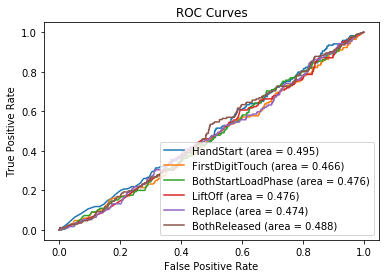

Train subject 10, class HandStart
Train on 3888 samples, validate on 972 samples
Epoch 1/100
3888/3888 [==============================] - 7s 2ms/step - loss: 0.5913 - acc: 0.7831 - val_loss: 0.5388 - val_acc: 0.8920
Epoch 2/100
3888/3888 [==============================] - 6s 2ms/step - loss: 0.5190 - acc: 0.8933 - val_loss: 0.5026 - val_acc: 0.8920
Epoch 3/100
3888/3888 [==============================] - 6s 2ms/step - loss: 0.4824 - acc: 0.8933 - val_loss: 0.4626 - val_acc: 0.8920
Epoch 4/100
3888/3888 [==============================] - 6s 2ms/step - loss: 0.4333 - acc: 0.8933 - val_loss: 0.4032 - val_acc: 0.8920
Epoch 5/100
3888/3888 [==============================] - 6s 2ms/step - loss: 0.3619 - acc: 0.8933 - val_loss: 0.3140 - val_acc: 0.8920
Epoch 6/100
3888/3888 [==============================] - 6s 2ms/step - loss: 0.2670 - acc: 0.8953 - val_loss: 0.2189 - val_acc: 0.9393
Epoch 7/100
3888/3888 [==============================] - 6s 2ms/step - loss: 0.1883 - acc: 0.9491 - val_loss:

Epoch 61/100
3888/3888 [==============================] - 6s 2ms/step - loss: 0.0499 - acc: 0.9879 - val_loss: 0.0552 - val_acc: 0.9866
Epoch 62/100
3888/3888 [==============================] - 6s 2ms/step - loss: 0.0496 - acc: 0.9882 - val_loss: 0.0547 - val_acc: 0.9866
Epoch 63/100
3888/3888 [==============================] - 6s 2ms/step - loss: 0.0494 - acc: 0.9884 - val_loss: 0.0539 - val_acc: 0.9866
Epoch 64/100
3888/3888 [==============================] - 6s 2ms/step - loss: 0.0494 - acc: 0.9892 - val_loss: 0.0547 - val_acc: 0.9866
Epoch 65/100
3888/3888 [==============================] - 6s 2ms/step - loss: 0.0492 - acc: 0.9887 - val_loss: 0.0557 - val_acc: 0.9866
Epoch 66/100
3888/3888 [==============================] - 6s 2ms/step - loss: 0.0489 - acc: 0.9879 - val_loss: 0.0533 - val_acc: 0.9866
Epoch 67/100
3888/3888 [==============================] - 6s 2ms/step - loss: 0.0493 - acc: 0.9887 - val_loss: 0.0535 - val_acc: 0.9866
Epoch 68/100
3888/3888 [========================

3888/3888 [==============================] - 6s 2ms/step - loss: 0.0654 - acc: 0.9874 - val_loss: 0.0632 - val_acc: 0.9877
Epoch 21/100
3888/3888 [==============================] - 6s 2ms/step - loss: 0.0640 - acc: 0.9877 - val_loss: 0.0627 - val_acc: 0.9877
Epoch 22/100
3888/3888 [==============================] - 6s 2ms/step - loss: 0.0634 - acc: 0.9877 - val_loss: 0.0617 - val_acc: 0.9877
Epoch 23/100
3888/3888 [==============================] - 6s 2ms/step - loss: 0.0621 - acc: 0.9877 - val_loss: 0.0607 - val_acc: 0.9877
Epoch 24/100
3888/3888 [==============================] - 6s 2ms/step - loss: 0.0614 - acc: 0.9877 - val_loss: 0.0599 - val_acc: 0.9877
Epoch 25/100
3888/3888 [==============================] - 6s 2ms/step - loss: 0.0601 - acc: 0.9877 - val_loss: 0.0591 - val_acc: 0.9877
Epoch 26/100
3888/3888 [==============================] - 6s 2ms/step - loss: 0.0600 - acc: 0.9877 - val_loss: 0.0587 - val_acc: 0.9877
Epoch 27/100
3888/3888 [==============================] - 6s 

KeyboardInterrupt: 

In [17]:


# models = []
# for i in range(N_LABELS):
#     models.append(init_cnn(WINDOW_SIZE))

for subject in TRAIN_SUBJECTS:
    prediction_total = []
    test_data_total = []
    train_data_paths = glob(TRAIN_DATA_PATH % (subject))

    
    x_raw, y_raw = read_training_data(train_data_paths)
    x_train, x_test, y_train, y_test = train_test_split(x_raw, y_raw, test_size=0.33, shuffle=False)

    x_train, _ = preprocess_data(x_train, WINDOW_SIZE, SUBSAMPLE)
    x_test, _ = preprocess_data(x_test, WINDOW_SIZE, SUBSAMPLE)
    y_train = y_train[::SUBSAMPLE]
    y_test = y_test[::SUBSAMPLE]
    
    for i in range(N_LABELS):
        model = init_cnn(WINDOW_SIZE)
        
        balanced_x_train, balanced_y_train = remove_imbalance(x_train, y_train[:,i])
        
        train_labels = to_categorical(balanced_y_train, num_classes = None)
                
        print('Train subject %d, class %s' % (subject, COLUMNS[i]))        
        model.fit(balanced_x_train, train_labels, verbose=1, validation_split=0.2, epochs=EPOCHS)
    
    
#     for task_name, model in zip(COLUMNS, models):
#         model.save('general_model_'+task_name+'_subject_%d.h5' % (subject))  # creates a HDF5 file 'my_model.h5'
        predictions = predict_on_sub(x_test, model, SPLIT_SIZE, BATCH_SIZE)
        
        test_data_total.append(y_test[:,i][1000::BATCH_SIZE])
        prediction_total.append(predictions)
        
    multiple_metric_auc_score(prediction_total, test_data_total, True)

In [19]:
prediction_total[0]

array([0.01672238, 0.01672238, 0.01672238, ..., 0.99921763, 0.99920839,
       0.99918479])

In [ ]:
# from keras.models import load_model
# for task_name, model in zip(COLUMNS, models):
#     model.save('general_model_'+task_name+'.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
# model = load_model('general_model_handstart.h5')

In [ ]:


# for subject in TEST_SUBJECTS:
#     prediction_total = []
#     test_data_total = []
#     test_features_raw = []
#     train_data_paths = glob(TRAIN_DATA_PATH % (subject))

    
#     x_raw, y_raw = read_training_data(train_data_paths)
    
#     x_raw, _ = preprocess_data(x_raw, WINDOW_SIZE, SUBSAMPLE)

#     _, x_test, _, y_test = train_test_split(x_raw, y_raw[::SUBSAMPLE], test_size=0.5)

    
#     for i in range(N_LABELS):

#         test_labels = to_categorical(y_test[:,i], num_classes = None)
                
#         print('Test subject %d, class %s' % (subject, COLUMNS[i]))                
#         predictions = predict_on_sub(x_test, models[i], SPLIT_SIZE, BATCH_SIZE)
        
#         test_data_total.append(y_test[:,i][1000::BATCH_SIZE])
#         prediction_total.append(predictions)
        
#     multiple_metric_auc_score(prediction_total, test_data_total, True)